In [20]:
import sys
print(sys.executable)

/mnt/homeGPU/jorgelerre/conda_envs/lichess_bot/bin/python


In [21]:
import os
import importlib

import chess
import chess.svg
from jax import random as jrandom
import jax
import jax.nn as jnn
import numpy as np
import matplotlib.pyplot as plt
import shap
import pandas as pd


In [22]:
from searchless_chess.src import transformer_xai, transformer
importlib.reload(transformer_xai)
importlib.reload(shap)
from searchless_chess.src import tokenizer
from searchless_chess.src import training_utils
from searchless_chess.src import utils
from searchless_chess.src.engines import engine
from searchless_chess.src.engines import neural_engines
from searchless_chess.src.engines import engine as engine_lib

#import searchless_chess.src.engines.constants as constants

In [23]:
# @title Create the predictor (9M)

policy = 'action_value'
num_return_buckets = 128
output_size = num_return_buckets
predictor_config = transformer.TransformerConfig(
    vocab_size=utils.NUM_ACTIONS,
    output_size=output_size,
    pos_encodings=transformer.PositionalEncodings.LEARNED,
    max_sequence_length=tokenizer.SEQUENCE_LENGTH + 2,
    num_heads=8,
    num_layers=8,
    embedding_dim=256,
    apply_post_ln=True,
    apply_qk_layernorm=False,
    use_causal_mask=False,
)

predictor = transformer.build_transformer_predictor(config=predictor_config)

In [24]:
# @title Load the predictor parameters
os.chdir("/mnt/homeGPU/jorgelerre/S-ChessFormer")
checkpoint_dir = os.path.join(
    os.getcwd(),
    f'searchless_chess/checkpoints/9M',
)
dummy_params = predictor.initial_params(
    rng=jrandom.PRNGKey(6400000),
    targets=np.zeros((1, 1), dtype=np.uint32),
)
params = training_utils.load_parameters(
    checkpoint_dir=checkpoint_dir,
    params=dummy_params,
    use_ema_params=True,
    step=-1,
)

In [25]:
# @title Create the engine
batch_size = 1
#jitted_predict_fn = jax.jit(predictor.predict)

#def fixed_predict_fn(sequences: np.ndarray) -> np.ndarray:
#    """Wrapper around the predictor `predict` function."""
#    assert sequences.shape[0] == batch_size
#    return jitted_predict_fn(
#        params=params,
#        targets=sequences,
#        rng=None,
#    )

#def predict_fn(sequences: np.ndarray) -> np.ndarray:
#    """Wrapper to collate batches of sequences of fixed size."""
#    remainder = -len(sequences) % batch_size
#    padded = np.pad(sequences, ((0, remainder), (0, 0)))
#    sequences_split = np.split(padded, len(padded) // batch_size)
#    all_outputs = []
#    for sub_sequences in sequences_split:
#        all_outputs.append(fixed_predict_fn(sub_sequences))
#    return all_outputs #outputs[: len(sequences)]  # Crop the padded sequences.



predict_fn = neural_engines.wrap_predict_fn(predictor, params, batch_size=batch_size)

In [26]:
_, return_buckets_values = utils.get_uniform_buckets_edges_values(
    num_return_buckets
)

engine_9M = neural_engines.ENGINE_FROM_POLICY[policy](
    return_buckets_values=return_buckets_values,
    predict_fn=predict_fn,
    temperature=0.0,
)

In [27]:
# Problemas básicos que estudiaremos
boards = [chess.Board("k7/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1"),
          chess.Board("k7/6b1/5q2/8/8/4Q3/5B2/1K6 b - - 0 1"),
          chess.Board("1k6/8/8/8/8/8/7P/1K6 w - - 0 1"),
          chess.Board("1k6/ppp4r/8/8/8/8/PPP3R1/1K6 w - - 0 1"),
          chess.Board("1k6/ppp4r/8/8/8/8/PPP3R1/1K6 b - - 0 1"),
          chess.Board("1k6/ppp4b/8/8/8/8/PPP3R1/1K6 w - - 0 1")]     

### Funciones auxiliares comunes

In [28]:
def get_sequences_from_board(board: chess.Board) -> np.ndarray:
    """Get the sequences from a chess board."""
    results = engine_9M.analyse(board)

    # Probs dadas en logaritmo. Hemos de deshacer el cambio
    buckets_log_probs = results["log_probs"]
    win_probs = np.inner(np.exp(buckets_log_probs), engine_9M._return_buckets_values)
    sorted_legal_moves = engine_lib.get_ordered_legal_moves(board)
    
    # Obtenemos el índice del movimiento que se va a jugar, que es el que mayor probabilidad tiene
    i = max(enumerate(win_probs), key=lambda x: x[1])[0]

    #print('sorted_legal_moves:', sorted_legal_moves)
    legal_actions = [utils.MOVE_TO_ACTION[x.uci()] for x in sorted_legal_moves]
    #print('legal_actions 1:', legal_actions)
    legal_actions = np.array(legal_actions, dtype=np.int32)
    #print('legal_actions 2:', legal_actions)
    legal_actions = np.expand_dims(legal_actions, axis=-1)
    #print('legal_actions 3:', legal_actions)
    #print('legal_actions.shape:', legal_actions.shape)
    # Tokenize the return buckets.
    dummy_return_buckets = np.zeros((len(legal_actions), 1), dtype=np.int32)
    #print('dummy_return_buckets:', dummy_return_buckets)
    #print('dummy_return_buckets.shape:', dummy_return_buckets.shape)
    # Tokenize the board.
    tokenized_fen = tokenizer.tokenize(board.fen()).astype(np.int32)
    #print('tokenized_fen:', tokenized_fen)
    #print('tokenized_fen.shape:', tokenized_fen.shape)
    sequences = np.stack([tokenized_fen] * len(legal_actions))
    #print('sequences:', sequences)
    #print('sequences.shape:', sequences.shape)
    # Create the sequences.
    sequences = np.concatenate(
        [sequences, legal_actions, dummy_return_buckets],
        axis=1,
    )
    return sequences

In [29]:
pos_labels = ['<turn>',
            'a8', 'b8', 'c8', 'd8', 'e8', 'f8', 'g8', 'h8',
            'a7', 'b7', 'c7', 'd7', 'e7', 'f7', 'g7', 'h7',
            'a6', 'b6', 'c6', 'd6', 'e6', 'f6', 'g6', 'h6',
            'a5', 'b5', 'c5', 'd5', 'e5', 'f5', 'g5', 'h5',
            'a4', 'b4', 'c4', 'd4', 'e4', 'f4', 'g4', 'h4',
            'a3', 'b3', 'c3', 'd3', 'e3', 'f3', 'g3', 'h3',
            'a2', 'b2', 'c2', 'd2', 'e2', 'f2', 'g2', 'h2',
            'a1', 'b1', 'c1', 'd1', 'e1', 'f1', 'g1', 'h1',
            '<castling_1>', '<castling_2>', '<castling_3>', 'castling_4>',
            '<en_passant_letter>','<en_passant_number>',
            '<halfmove_1>', '<halfmove_2>', '<halfmove_3>',
            '<fullmove_1>', '<fullmove_2>', '<fullmove_3>', 
            'move', 'padding']

In [30]:
def predict_fn_xai(input_array):
    """
    input_array: np.array of shape (n_samples, 79)
    returns: np.array of shape (n_samples, 1)
    """
    input_array = input_array.astype(np.int32)
    results = predict_fn(input_array)
    log_probs = results[:, -1]
    win_probs = np.inner(np.exp(log_probs), engine_9M._return_buckets_values)
    print('win_probs:', win_probs)
    return win_probs

# SHAP

### Background vacío

In [33]:
tokenized_boards = [get_sequences_from_board(board) for board in boards]

background =  np.array([[11, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,  0,
 30, 30,  1, 30, 30, 24,  0]])

explainer = shap.KernelExplainer(predict_fn_xai, background, algorithm="partition")  # o kernel
i=0
shap_values = {}

for tokenized_board in tokenized_boards:
    shap_values[boards[i].fen()] = explainer(tokenized_board[0].reshape(1,-1)) 
    i=i+1

win_probs: [0.49624801]


  0%|          | 0/1 [00:00<?, ?it/s]

win_probs: [0.22001301]
win_probs: [0.49620038 0.00476877 0.49665015 0.13547325 0.54648559 0.51707503
 0.83339693 0.97662931 0.23321962 0.01226839 0.53547374 0.18914815
 0.49703062 0.75576907 0.4991271  0.5030923  0.50893555 0.00442794
 0.06553083 0.01430136 0.49642091 0.94021194 0.49618388 0.50343665
 0.49644999 0.00513413 0.70273317 0.50438322 0.98574167 0.9878496
 0.00708915 0.00746194 0.5319735  0.09427337 0.49613101 0.49684335
 0.80095223 0.99438477 0.01738606 0.08875487 0.50056074 0.50106861
 0.47541771 0.85400026 0.37052726 0.50157608 0.95131076 0.89333863
 0.80952355 0.99590357 0.00649122 0.01728931 0.53109667 0.03157785
 0.49660603 0.52066857 0.5330354  0.51742815 0.10938487 0.59979429
 0.94499782 0.94480625 0.49324755 0.50563639 0.4962654  0.49122164
 0.00903054 0.02380629 0.9350361  0.84035965 0.50112948 0.49853011
 0.53488172 0.00407046 0.44006358 0.49681067 0.04926879 0.71655568
 0.0907667  0.00390841 0.52300648 0.98771237 0.74985694 0.97568935
 0.49614043 0.49169664 0.873

  0%|          | 0/1 [00:00<?, ?it/s]

win_probs: [0.51087743]
win_probs: [0.49665015 0.66206523 0.54648559 0.00651014 0.83339693 0.00396837
 0.23321962 0.97393931 0.53547374 0.52926066 0.49703062 0.24120695
 0.49621507 0.00476877 0.70273317 0.01219096 0.98574167 0.02574631
 0.00708915 0.99452193 0.5319735  0.766411   0.49613101 0.4934201
 0.4963001  0.5030923  0.80095223 0.00392951 0.01738606 0.53499716
 0.50056074 0.10010578 0.47541771 0.07236857 0.4999888  0.00442794
 0.37052726 0.49788453 0.95131076 0.08074218 0.80952355 0.00393774
 0.99418004 0.01430136 0.00649122 0.99179365 0.53109667 0.98843737
 0.05243899 0.94021194 0.49660603 0.49185317 0.51575224 0.50343665
 0.49653404 0.00513413 0.87342159 0.01294043 0.03361926 0.50397809
 0.50316439 0.04490858 0.47344479 0.18258525 0.61688399 0.51742815
 0.1331336  0.49673859 0.92728572 0.05521393 0.57788192 0.03237561
 0.98992969 0.59979429 0.00390683 0.99514864 0.40313994 0.99135121
 0.03296738 0.94480625 0.52828301 0.44913508 0.50702386 0.50563639
 0.49611196 0.49122164 0.492

  0%|          | 0/1 [00:00<?, ?it/s]

win_probs: [0.50075758]
win_probs: [0.49620038 0.12001276 0.49752249 0.69861047 0.54073395 0.49617131
 0.49703062 0.52174702 0.49612457 0.50035838 0.4982726  0.1189577
 0.50614817 0.49610779 0.49644999 0.44588743 0.49618811 0.12924194
 0.51330259 0.49637479 0.49612975 0.50622397 0.49611277 0.7642395
 0.16351212 0.49635281 0.51600265 0.49622789 0.49661414 0.52577843]


  0%|          | 0/1 [00:00<?, ?it/s]

win_probs: [0.00390649]
win_probs: [0.49620038 0.0039084  0.49752249 ... 0.09375945 0.50444306 0.49562695]


  0%|          | 0/1 [00:00<?, ?it/s]

win_probs: [0.50304632]
win_probs: [0.49752249 0.49635676 0.49815977 ... 0.98316126 0.02409722 0.97328332]


  0%|          | 0/1 [00:00<?, ?it/s]

win_probs: [0.73584064]
win_probs: [0.49620038 0.11501301 0.49752249 ... 0.49777006 0.31693088 0.4964588 ]


In [42]:
shap_values['k7/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1'].feature_names

['<turn>',
 'a8',
 'b8',
 'c8',
 'd8',
 'e8',
 'f8',
 'g8',
 'h8',
 'a7',
 'b7',
 'c7',
 'd7',
 'e7',
 'f7',
 'g7',
 'h7',
 'a6',
 'b6',
 'c6',
 'd6',
 'e6',
 'f6',
 'g6',
 'h6',
 'a5',
 'b5',
 'c5',
 'd5',
 'e5',
 'f5',
 'g5',
 'h5',
 'a4',
 'b4',
 'c4',
 'd4',
 'e4',
 'f4',
 'g4',
 'h4',
 'a3',
 'b3',
 'c3',
 'd3',
 'e3',
 'f3',
 'g3',
 'h3',
 'a2',
 'b2',
 'c2',
 'd2',
 'e2',
 'f2',
 'g2',
 'h2',
 'a1',
 'b1',
 'c1',
 'd1',
 'e1',
 'f1',
 'g1',
 'h1',
 '<castling_1>',
 '<castling_2>',
 '<castling_3>',
 'castling_4>',
 '<en_passant_letter>',
 '<en_passant_number>',
 '<halfmove_1>',
 '<halfmove_2>',
 '<halfmove_3>',
 '<fullmove_1>',
 '<fullmove_2>',
 '<fullmove_3>',
 'move',
 'padding']

Importancia SHAP para el FEN k7/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1


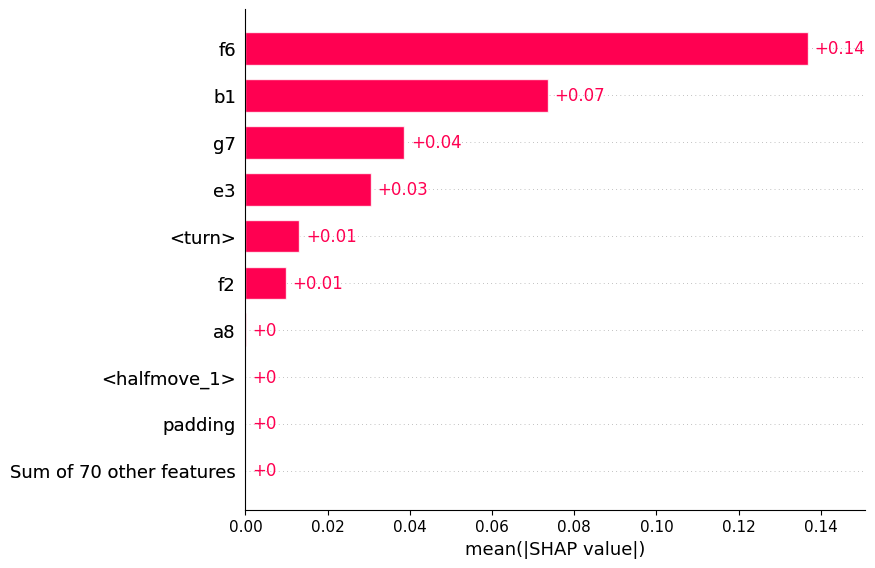

feature_weights: [('=<turn>', array([ 1.30985301e-02,  1.15701336e-04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.86777248e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.36850612e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -3.05711036e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e

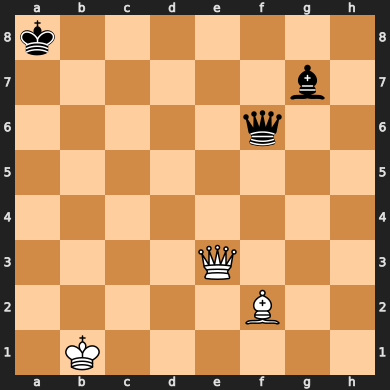

Importancia SHAP para el FEN k7/6b1/5q2/8/8/4Q3/5B2/1K6 b - - 0 1


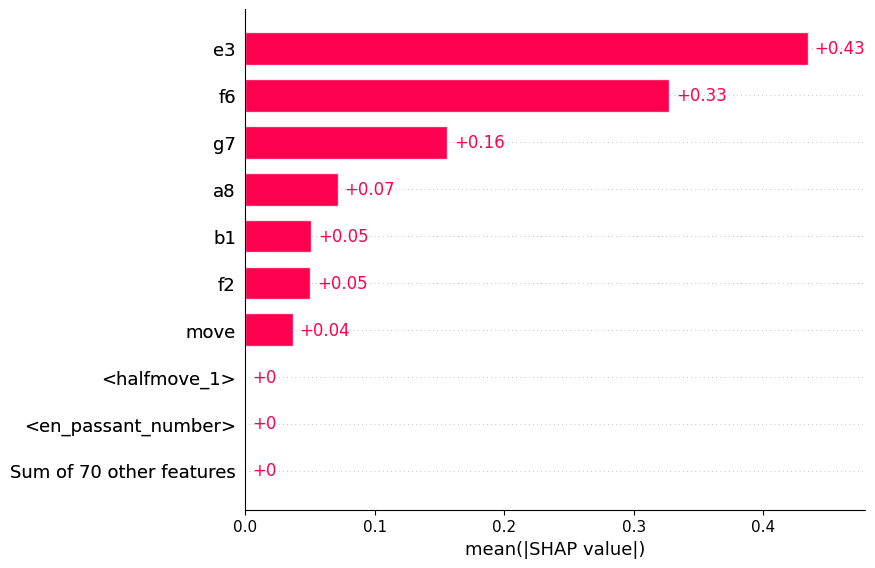

feature_weights: [('=<turn>', array([ 0.        , -0.07158949,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.15585844,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.32751089,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.43453557,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.05010074,
        0.        ,  0.        ,  0.        ,  0.05081546,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  

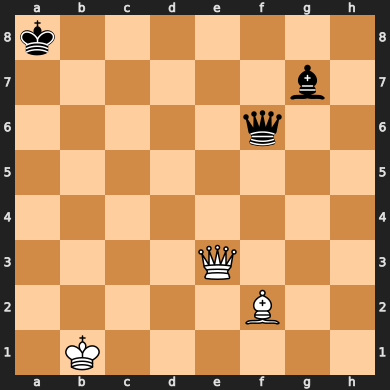

Importancia SHAP para el FEN 1k6/8/8/8/8/8/7P/1K6 w - - 0 1


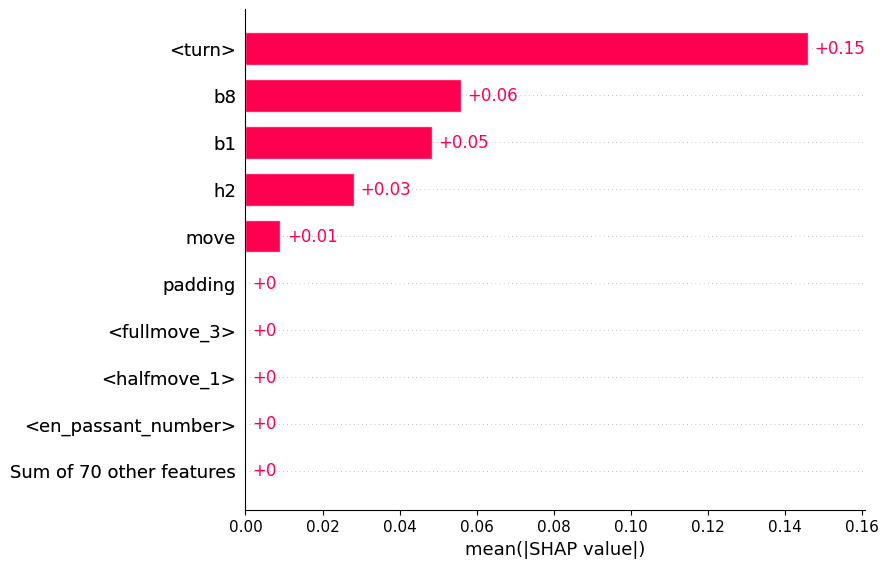

feature_weights: [('=<turn>', array([ 0.14587386,  0.        , -0.05584856,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.02811253,  0.        , -0.04838553,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  

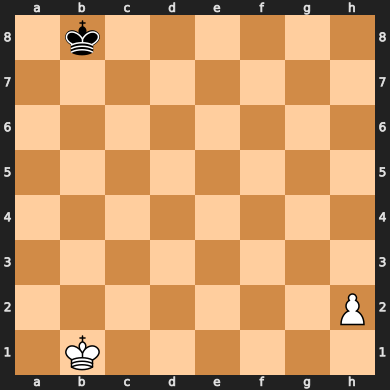

Importancia SHAP para el FEN 1k6/ppp4r/8/8/8/8/PPP3R1/1K6 w - - 0 1


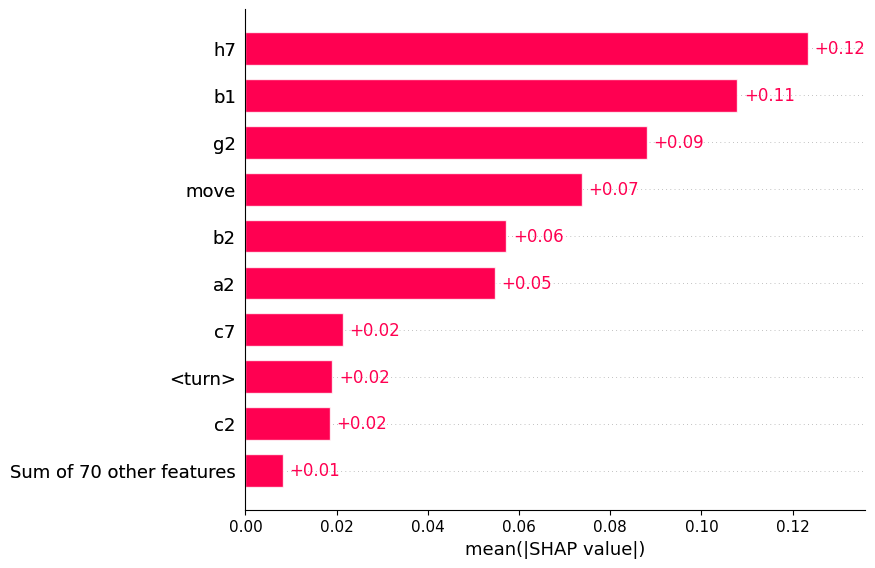

feature_weights: [('=<turn>', array([-0.01906264,  0.        , -0.00819639,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.02138227,  0.        ,  0.        ,  0.        ,
        0.        , -0.12332243,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.05470269,
       -0.05723796,  0.01845595,  0.        ,  0.        ,  0.        ,
       -0.08806711,  0.        ,  0.        , -0.10788201,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  

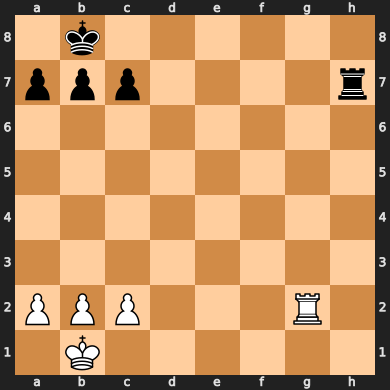

Importancia SHAP para el FEN 1k6/ppp4r/8/8/8/8/PPP3R1/1K6 b - - 0 1


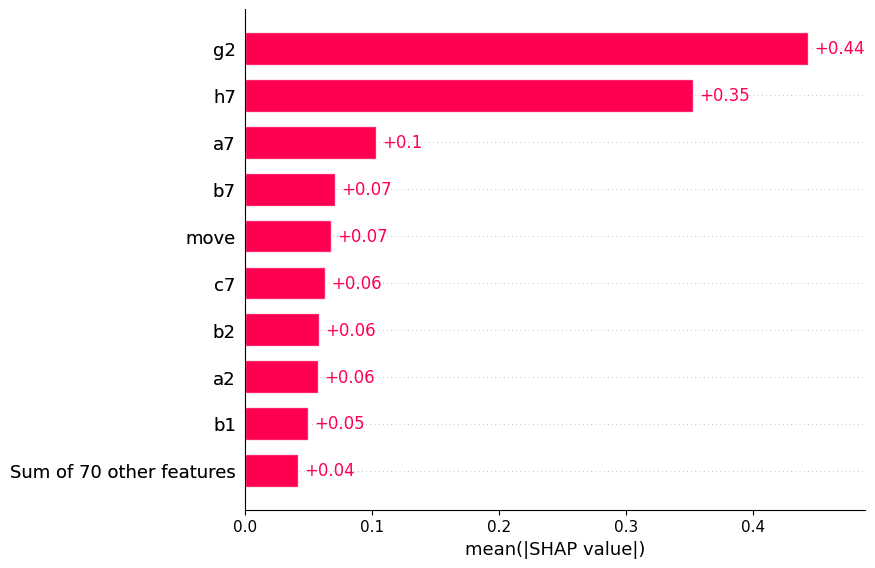

feature_weights: [('=<turn>', array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.10283942,
        0.07061523,  0.06252815,  0.        ,  0.        ,  0.        ,
        0.        ,  0.35263499,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.05726692,
       -0.05796696, -0.04150925,  0.        ,  0.        ,  0.        ,
       -0.44326257,  0.        ,  0.        , -0.04902541,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  

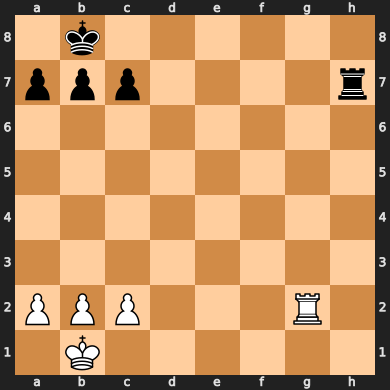

Importancia SHAP para el FEN 1k6/ppp4b/8/8/8/8/PPP3R1/1K6 w - - 0 1


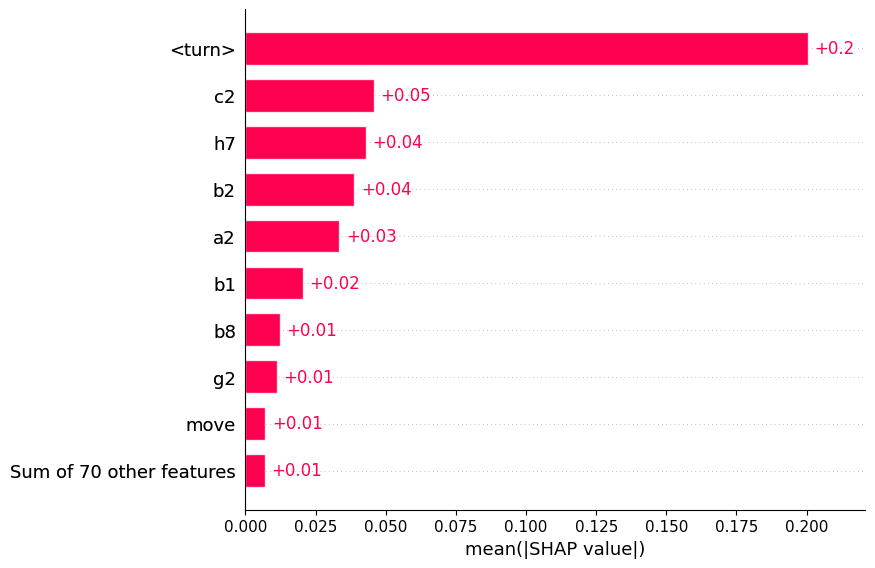

feature_weights: [('=<turn>', array([ 0.20043251,  0.        , -0.01230733,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.0069136 ,  0.        ,  0.        ,  0.        ,
        0.        , -0.04297459,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.03344734,
        0.03878665,  0.04566311,  0.        ,  0.        ,  0.        ,
        0.01113751,  0.        ,  0.        , -0.02055069,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  

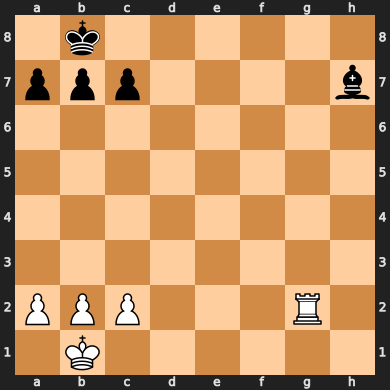

In [48]:
for key, value in shap_values.items():
    value.feature_names = pos_labels
    print(f'Importancia SHAP para el FEN {key}')
    shap.plots.bar(value,max_display=10)
    feature_weights = [(f"={k}", v) for k, v in zip(value.feature_names, value.values)]
    print('feature_weights:', feature_weights)
    dibujar_tablero_con_mapa(key, feature_weights)

### Con background

In [ ]:
tokenized_boards = [get_sequences_from_board(board) for board in boards]

puzzles_background = pd.read_csv('problemas/unsolved_puzzles/SBP_HARD.csv')
print(puzzles_background)
puzzles_background['tokenized_board'] = puzzles_background['FEN'].apply(lambda fen: get_sequences_from_board(chess.Board(fen)))
print(puzzles_background)

                                                   FEN Moves Moves_UCI
0    1r3rk1/p1n2ppp/b7/P1p1P3/1pNbN3/1P4PB/5P1P/2RR...  Ncd6      c4d6
1    5rk1/4qpbp/1p2r1p1/pNp1n3/2Pp2P1/3P3P/PP1BPRQ1...    g5      g6g5
2    8/1prr1pkp/4nRp1/2qB2P1/pp2P1PP/P5Q1/1P6/1K3R2...  axb4      a3b4
3    r4r1k/p1pb4/1p1p3p/3Pq3/2P2p2/3pBN2/PPQ2P1P/6R...  Qxd3      c2d3
4    2k4r/2p2rpp/3b1n2/Npp1p1B1/4P3/3R1P2/PP3P1P/3R...   Rb3      d3b3
..                                                 ...   ...       ...
381  2r3rk/5p1p/p3pPp1/1b2P1QP/1p4P1/1P2p3/P1P2qB1/...   Be4      g2e4
382  2r1k2r/1b2qpp1/p2p4/1p2pP2/3NP1pP/8/PPPQ2P1/1K...    f6      f5f6
383  1r1qr1k1/1p3ppp/p1np2b1/2pN4/2P2P2/1P1PPB1P/PQ...   Be4      f3e4
384  3rr1k1/pb4pp/1p2p3/4qp1Q/2P5/1P5P/P1B2PP1/3R1R...   Rd7      d1d7
385  r5k1/4nppp/2qp1b2/1p2p3/4P3/2PQBN2/1P3PPP/3R2K...   Ne1      f3e1

[386 rows x 3 columns]
                                                   FEN Moves Moves_UCI  \
0    1r3rk1/p1n2ppp/b7/P1p1P3/1pNbN3/1P4PB/5P1P/2R

In [ ]:

#print(predict_fn_shap_2(df.to_numpy()))

init_board = chess.Board()
puzzles_list = puzzles_background['tokenized_board'].tolist()
print(len(puzzles_list))
background = np.vstack(puzzles_list)
np.random.shuffle(background)
background = background[:5]  # Use a subset for the background
print(background.shape)

explainer = shap.KernelExplainer(predict_fn_xai, background, algorithm="partition")  # o kernel
i=0
shap_values = {}

for tokenized_board in tokenized_boards:
    shap_values[boards[i].fen()] = explainer(tokenized_board[0].reshape(1,-1)) 
    i=i+1

386
(5, 79)
win_probs: [0.50905782 0.47427119 0.1179728  0.12201077 0.44079418]


  0%|          | 0/1 [00:00<?, ?it/s]

win_probs: [0.22001301]
win_probs: [0.50905782 0.2508441  0.1179728  ... 0.25148267 0.22001301 0.22001301]


  0%|          | 0/1 [00:00<?, ?it/s]

win_probs: [0.51087743]
win_probs: [0.47802952 0.47427119 0.91844443 ... 0.00391499 0.17522221 0.89486933]


  0%|          | 0/1 [00:00<?, ?it/s]

win_probs: [0.50075758]
win_probs: [0.50905782 0.2508441  0.1179728  ... 0.96493574 0.13975794 0.97771649]


  0%|          | 0/1 [00:00<?, ?it/s]

win_probs: [0.00390649]
win_probs: [0.50905782 0.2508441  0.1179728  ... 0.08514165 0.67909388 0.82543199]


  0%|          | 0/1 [00:00<?, ?it/s]

win_probs: [0.50304632]
win_probs: [0.47802952 0.47427119 0.91844443 ... 0.86995837 0.50635299 0.93139862]


  0%|          | 0/1 [00:00<?, ?it/s]

win_probs: [0.73584064]
win_probs: [0.50905782 0.2508441  0.1179728  ... 0.93076089 0.00390696 0.02849609]


Importancia SHAP para el FEN k7/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1


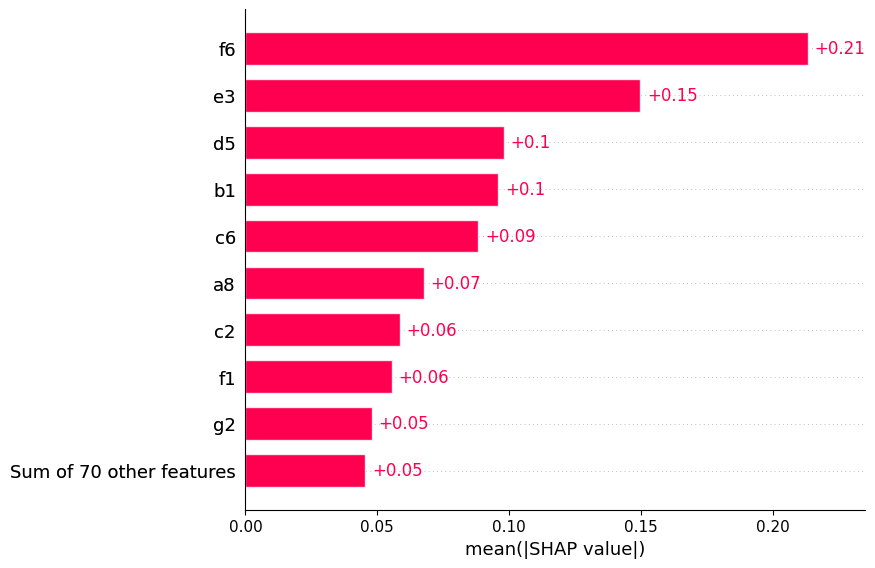

Importancia SHAP para el FEN k7/6b1/5q2/8/8/4Q3/5B2/1K6 b - - 0 1


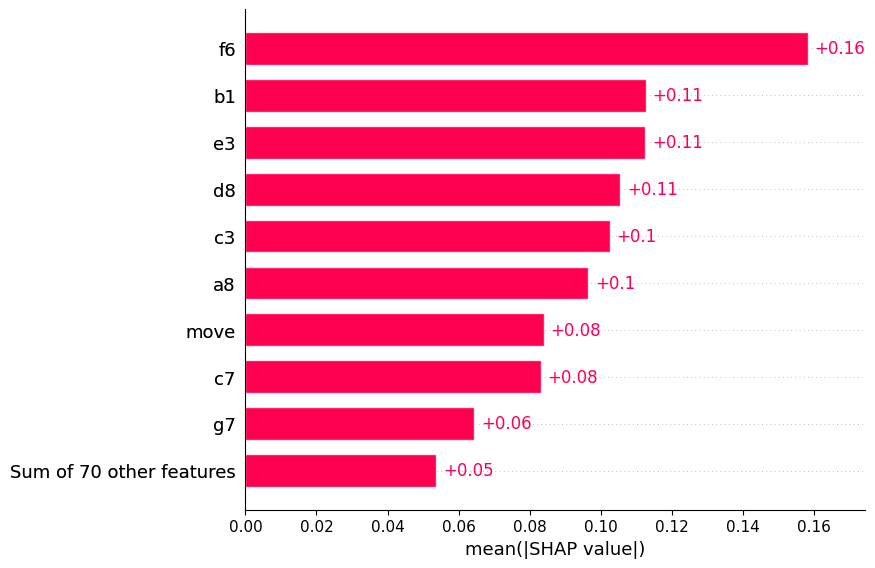

Importancia SHAP para el FEN 1k6/8/8/8/8/8/7P/1K6 w - - 0 1


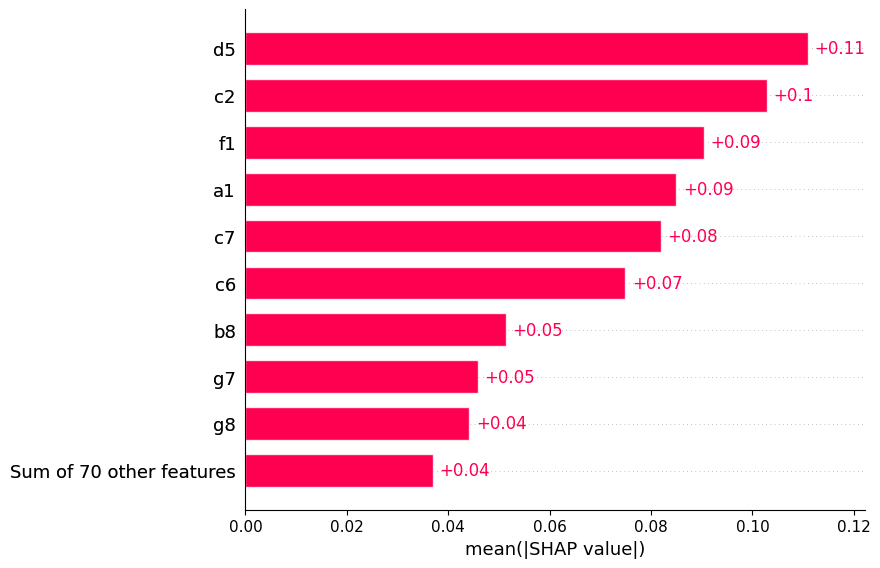

Importancia SHAP para el FEN 1k6/ppp4r/8/8/8/8/PPP3R1/1K6 w - - 0 1


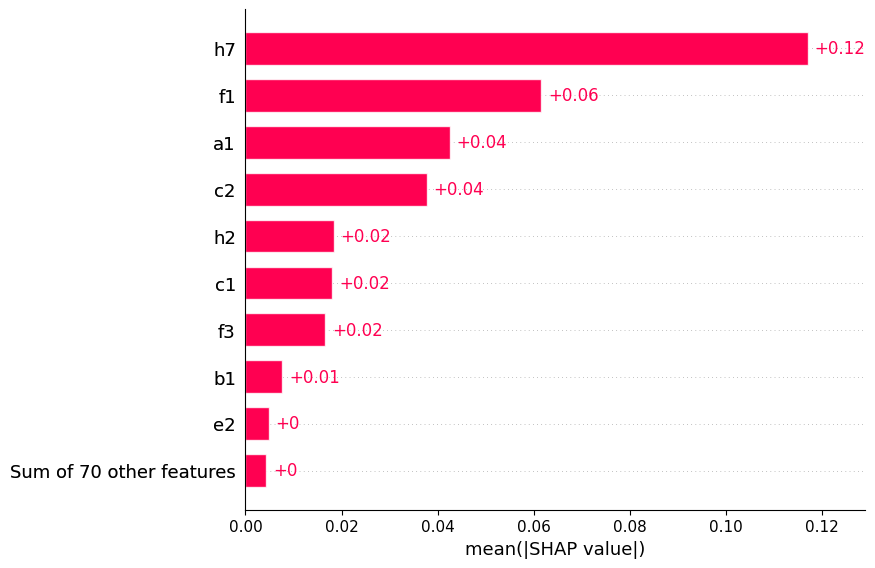

Importancia SHAP para el FEN 1k6/ppp4r/8/8/8/8/PPP3R1/1K6 b - - 0 1


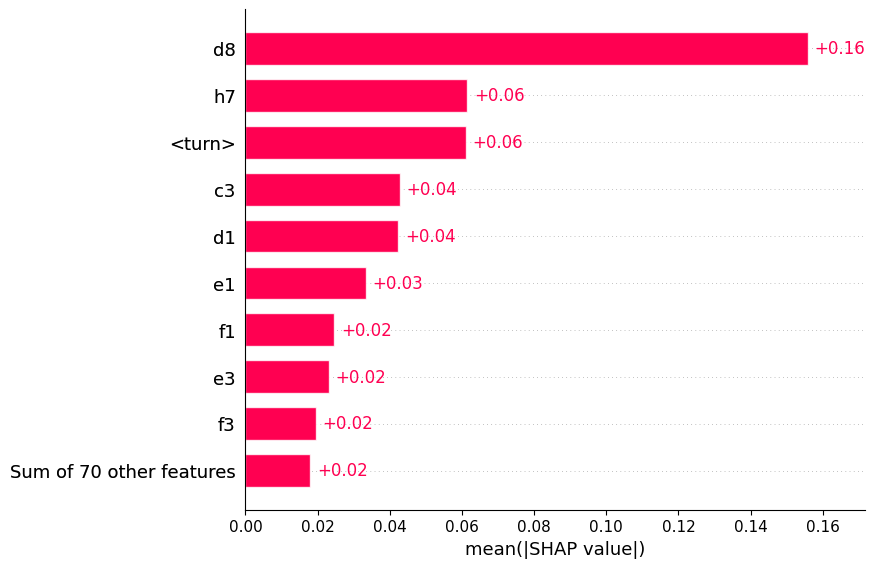

Importancia SHAP para el FEN 1k6/ppp4b/8/8/8/8/PPP3R1/1K6 w - - 0 1


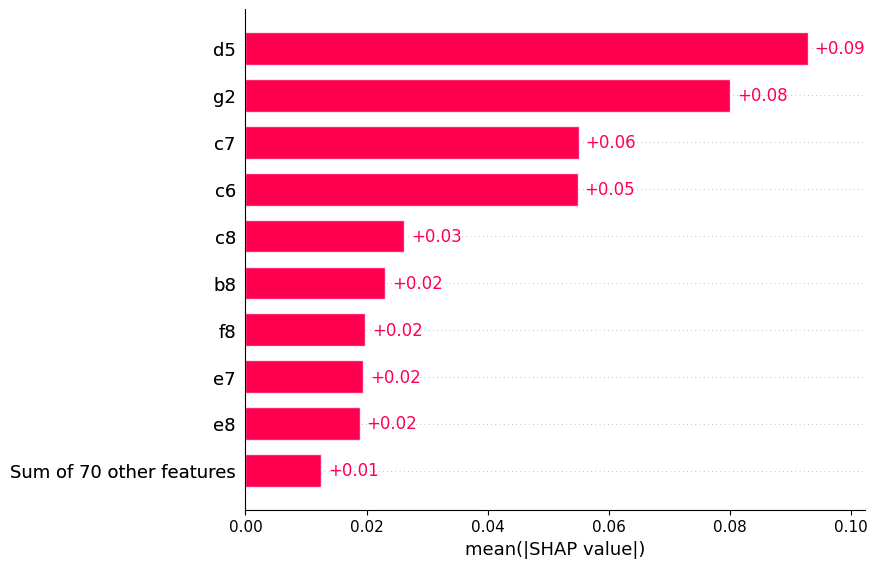

In [23]:
for key, value in shap_values.items():
    value.feature_names = pos_labels
    print(f'Importancia SHAP para el FEN {key}')
    shap.plots.bar(value,max_display=10)

In [ ]:
def apply_shap_to_fen(fen :str, move:str):
    """
    Apply SHAP to a FEN string.
    fen: str
    returns: shap_values: np.array of shape (n_samples, 1)
    """
    board = chess.Board(fen)
    legal_moves = engine_lib.get_ordered_legal_moves(board)
    move_index = np.where([move == x.uci() for x in legal_moves])[0][0]
    print('move_index:', move_index)
    tokenized_board = get_sequences_from_board(board)
    background = [11, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,  0,
 30, 30,  1, 30, 30, 24,  0]

    explainer = shap.Explainer(predict_fn_xai, background, algorithm="partition")  # o kernel
    shap_values = explainer(tokenized_board[move_index]) #.reshape(1, -1))
    return shap_values

In [ ]:
shap_values_2 = apply_shap_to_fen("k7/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1")

In [82]:
board = chess.Board("k7/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1")
engine_lib.get_ordered_legal_moves(board)
print(get_sequences_from_board(board)[3])

[ 29  21  30  30  30  30  30  30  30  30  30  30  30  30  30  11  30  30
  30  30  30  30  22  30  30  30  30  30  30  30  30  30  30  30  30  30
  30  30  30  30  30  30  30  30  30  27  30  30  30  30  30  30  30  30
  24  30  30  30  28  30  30  30  30  30  30  30  30  30  30  30  30   0
  30  30   1  30  30 332   0]


cohort_exps [.values =
array([7.28319311e-03, 2.24486249e-03, 7.28319311e-03, 7.28319311e-03,
       7.28319311e-03, 2.24486249e-03, 7.28319311e-03, 2.24486249e-03,
       7.28319311e-03, 7.28319311e-03, 7.28319311e-03, 2.24486249e-03,
       2.24486249e-03, 7.28319311e-03, 6.63558547e-02, 7.28319311e-03,
       4.66145135e-02, 7.28319311e-03, 7.28319311e-03, 7.28319311e-03,
       7.28319311e-03, 7.28319311e-03, 1.75102314e-01, 7.28319311e-03,
       0.00000000e+00, 1.69848161e-03, 7.28319311e-03, 7.28319311e-03,
       7.28319311e-03, 7.28319311e-03, 1.56722826e-03, 2.24486249e-03,
       2.24486249e-03, 7.28319311e-03, 7.28319311e-03, 2.24486249e-03,
       7.28319311e-03, 7.28319311e-03, 1.38598566e-03, 7.28319311e-03,
       7.28319311e-03, 7.28319311e-03, 4.62009243e-06, 7.28319311e-03,
       3.19391390e-04, 7.28319311e-03, 7.28319311e-03, 7.28319311e-03,
       1.56722826e-03, 2.24486249e-03, 7.28319311e-03, 7.28319311e-03,
       7.28319311e-03, 2.24486249e-03, 2.79928605e-02,

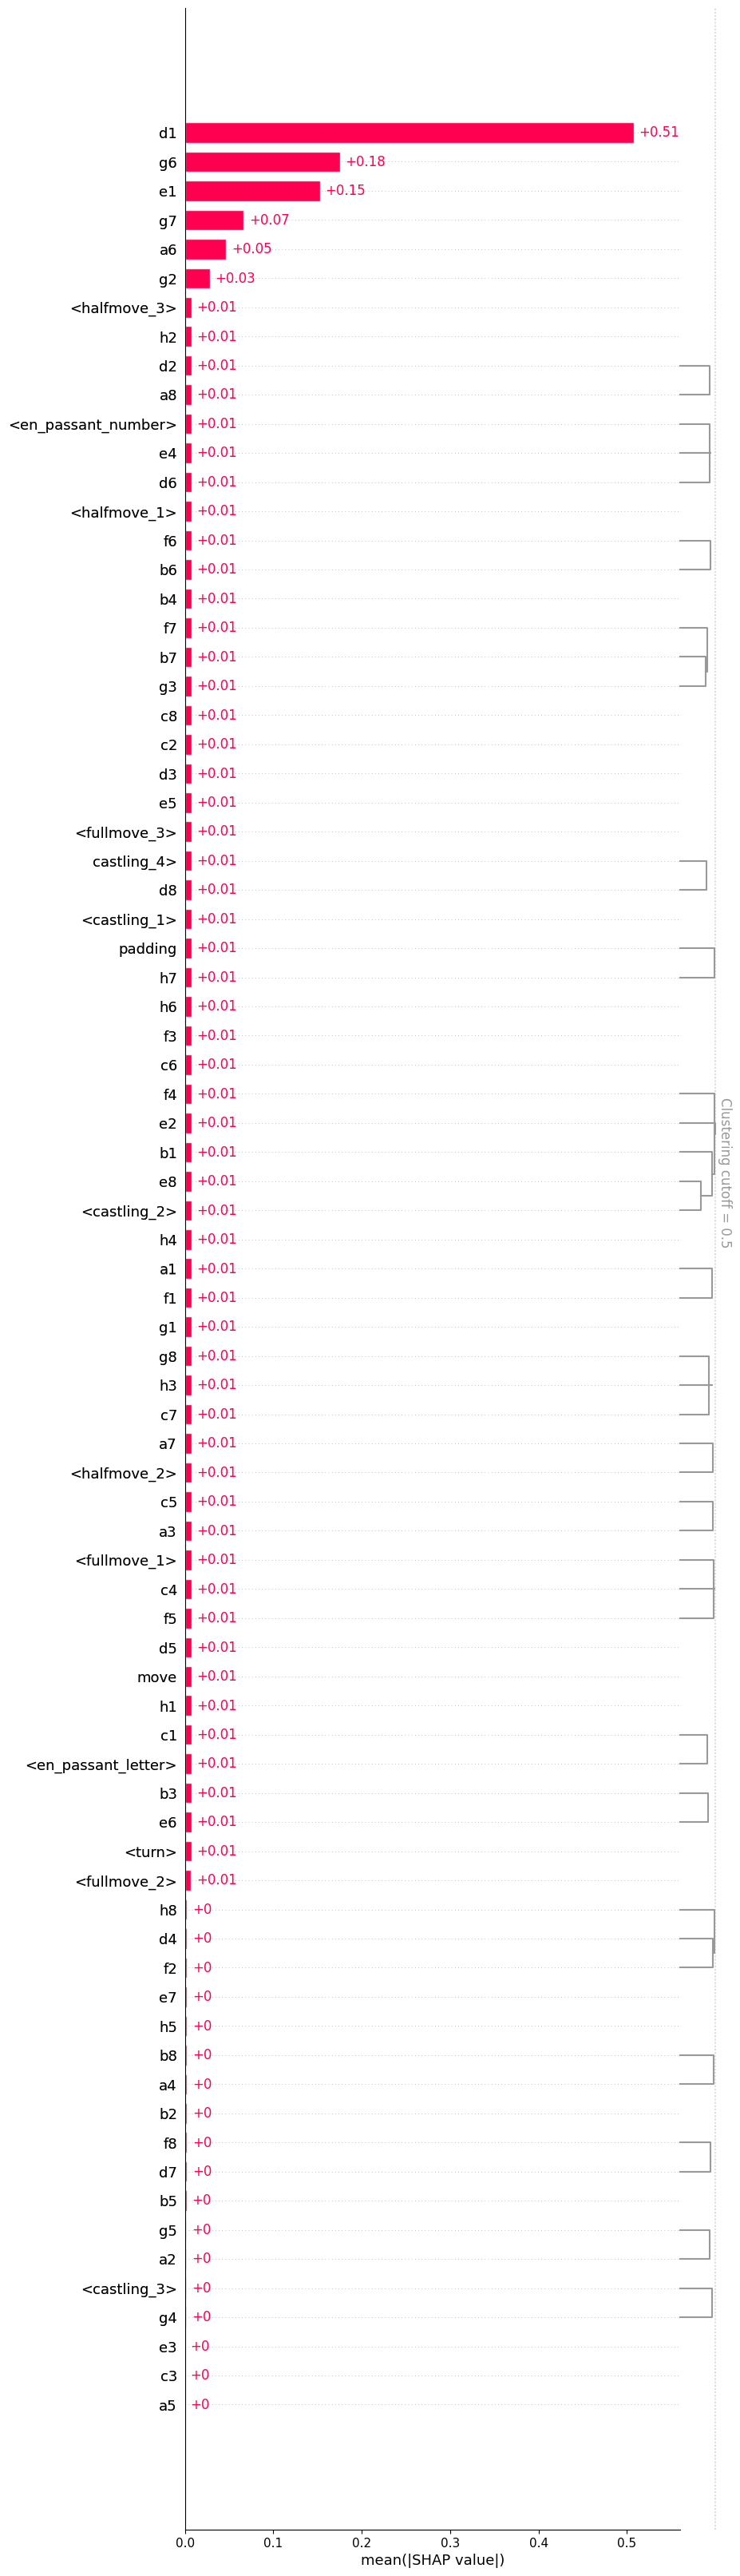

In [75]:
shap.plots.bar(shap_values_2, max_display=None)

In [72]:
shap_values_2 = apply_shap_to_fen("k7/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1")
shap_values_2.feature_names = pos_labels
shap.plots.bar(shap_values_2, max_display=None)

win_probs: [0.44856247 0.51256398 0.52623912 0.44132425 0.49607814 0.48029971
 0.49112228 0.45736975 0.50015001 0.5240488  0.49503955 0.53068737
 0.51578471 0.53516419 0.4374244  0.47963619 0.50797202 0.41181972
 0.48828592 0.47182889]
win_probs: [0.22001261 0.22001261 0.22001261 0.22001261 0.22001261 0.22001261
 0.22001261 0.22001261 0.22001261 0.22001261 0.22001261 0.22001261
 0.22001261 0.22001261 0.22001261 0.22001261 0.22001261 0.22001261
 0.22001261 0.22001261]
win_probs: [0.44856247 0.51256398 0.52623912 0.44132425 0.49607814 0.48029971
 0.49112228 0.45736975 0.50015001 0.5240488  0.49503955 0.53068737
 0.51578471 0.53516419 0.4374244  0.47963619 0.50797202 0.41181972
 0.48828592 0.47182889 0.22001261 0.22001261 0.22001261 0.22001261
 0.22001261 0.22001261 0.22001261 0.22001261 0.22001261 0.22001261
 0.22001261 0.22001261 0.22001261 0.22001261 0.22001261 0.22001261
 0.22001261 0.22001261 0.22001261 0.22001261]
win_probs: [0.02185368 0.02789926 0.02879855 0.0196428  0.02983801 0.

  0%|          | 0/498 [00:00<?, ?it/s]

win_probs: [0.44322996 0.50782314 0.52034395 0.43696279 0.48815979 0.4715061
 0.48317798 0.45502349 0.49296944 0.51653266 0.48329412 0.52370183
 0.50974058 0.52963037 0.43159682 0.46878992 0.49502977 0.41077338
 0.47978957 0.46867866 0.02225794 0.02899316 0.03157554 0.01982345
 0.04086764 0.05074961 0.01366769 0.01280253 0.03808489 0.08635783
 0.06391272 0.08729022 0.05460229 0.07259213 0.02016911 0.02152626
 0.20691559 0.01947005 0.0377832  0.04861835 0.21477728 0.21477728
 0.21477728 0.21477728 0.21477728 0.21477728 0.21477728 0.21477728
 0.21477728 0.21477728 0.21477728 0.21477728 0.21477728 0.21477728
 0.21477728 0.21477728 0.21477728 0.21477728 0.21477728 0.21477728
 0.97629376 0.97629376 0.97629376 0.97629376 0.97629376 0.97629376
 0.97629376 0.97629376 0.97629376 0.97629376 0.97629376 0.97629376
 0.97629376 0.97629376 0.97629376 0.97629376 0.97629376 0.97629376
 0.97629376 0.97629376 0.21477728 0.21477728 0.21477728 0.21477728
 0.21477728 0.21477728 0.21477728 0.21477728 0.21477

PartitionExplainer explainer:   3%| | 1/30 [00:00<?, ?it/s]

win_probs: [0.44856247 0.51256398 0.52623912 0.44132425 0.49607814 0.48029971
 0.49112228 0.45736975 0.50015001 0.5240488  0.49503955 0.53068737
 0.51578471 0.53516419 0.4374244  0.47963619 0.50797202 0.41181972
 0.48828592 0.47182889]
win_probs: [0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908]
win_probs: [0.44856247 0.51256398 0.52623912 0.44132425 0.49607814 0.48029971
 0.49112228 0.45736975 0.50015001 0.5240488  0.49503955 0.53068737
 0.51578471 0.53516419 0.4374244  0.47963619 0.50797202 0.41181972
 0.48828592 0.47182889 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908 0.00394908 0.00394908]
win_probs: [0.02185368 0.02789926 0.02879855 0.0196428  0.02983801 0.

  0%|          | 0/498 [00:00<?, ?it/s]

win_probs: [0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908 0.98085142 0.98085142 0.98085142 0.98085142
 0.98085142 0.98085142 0.98085142 0.98085142 0.98085142 0.98085142
 0.98085142 0.98085142 0.98085142 0.98085142 0.98085142 0.98085142
 0.98085142 0.98085142 0.98085142 0.98085142 0.00394908 0.00394908
 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908 0.00394908
 0.98085142 0.98085142 0.98085142 0.98085142 0.98085142 0.98085142
 0.98085142 0.98085142 0.98085142 0.98085142 0.98085142 0.98085142
 0.98085142 0.98085142 0.98085142 0.98085142 0.98085142 0.98085142
 0.98085142 0.98085142 0.0039425  0.0039425  0.0039425  0.0039425
 0.0039425  0.0039425  0.0039425  0.0039425  0.00394

PartitionExplainer explainer:   7%| | 2/30 [07:36<3:33:06, 


KeyboardInterrupt: 

In [36]:
print(df.shape)

(47, 79)


In [22]:
shap_values.values

array([[[-0.04635842],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0

  0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

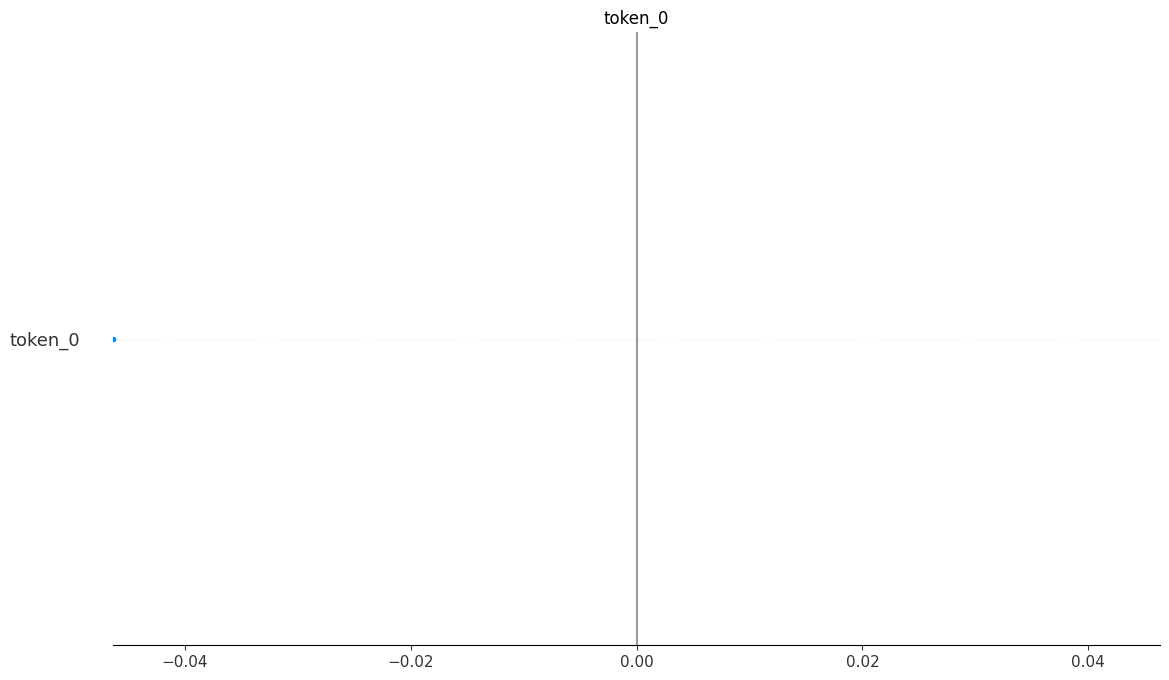

In [18]:
sequence_reshaped = sequence.reshape(1, -1)
shap_values = explainer(sequence_reshaped)

# Forzar nombres de características
shap_values.feature_names = [f"token_{i}" for i in range(sequence_reshaped.shape[1])]

# Asignar datos como matriz 2D (no uses [0])
shap_values.data = sequence_reshaped.astype(np.float32)

# Summary plot
shap.summary_plot(
    shap_values.values,
    shap_values.data,
    feature_names=shap_values.feature_names,
    plot_type="bar",  # o "dot"
    show=True
)


In [15]:
print(shap_values)

.values =
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
  

In [14]:
# @title Compute the win percentages for all legal moves

board = chess.Board("r1br2k1/1pp2p1p/n5p1/p3q3/P1Q1P3/2N3P1/1P3PBP/R4RK1 b - - 0 1")
results = engine_9M.analyse(board)
print(results)
buckets_log_probs = results['log_probs']

# Compute the expected return.
win_probs = np.inner(np.exp(buckets_log_probs), return_buckets_values)
sorted_legal_moves = engine.get_ordered_legal_moves(board)

print(board.fen())
print(f'Win percentages:')
for i in np.argsort(win_probs)[::-1]:
  print(f'  {sorted_legal_moves[i].uci()} -> {100*win_probs[i]:.1f}%')

{'log_probs': array([[-14.456982 , -17.918943 , -17.833376 , ..., -19.492619 ,
        -19.647696 , -17.849249 ],
       [-13.880351 , -15.478263 , -15.105826 , ..., -18.719418 ,
        -18.434452 , -16.80056  ],
       [-13.903162 , -15.8539505, -15.258402 , ..., -15.260092 ,
        -15.692844 , -14.4004135],
       ...,
       [-16.072968 , -17.287943 , -16.847778 , ..., -16.858864 ,
        -16.975084 , -16.52268  ],
       [-16.309505 , -17.30768  , -16.871548 , ..., -16.777864 ,
        -16.91726  , -16.426367 ],
       [-14.061224 , -15.891546 , -15.576529 , ..., -16.08771  ,
        -16.16223  , -15.486992 ]], shape=(47, 128), dtype=float32), 'fen': 'r1br2k1/1pp2p1p/n5p1/p3q3/P1Q1P3/2N3P1/1P3PBP/R4RK1 b - - 0 1'}
r1br2k1/1pp2p1p/n5p1/p3q3/P1Q1P3/2N3P1/1P3PBP/R4RK1 b - - 0 1
Win percentages:
  c7c6 -> 57.5%
  c8e6 -> 56.5%
  c8g4 -> 52.5%
  d8d4 -> 52.3%
  e5c5 -> 52.2%
  a6b4 -> 52.1%
  g8g7 -> 52.1%
  c8d7 -> 51.9%
  a8b8 -> 51.5%
  d8d2 -> 51.0%
  h7h5 -> 50.9%
  h7h6 -> 49.

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# LIME

In [8]:
from lime.lime_tabular import LimeTabularExplainer
import random

### Old version

In [ ]:
# Desde dentro de la casilla (piece_col,piece_row) hacia fuera se hace un recorrido en sentido horario, aumentando la distancia a casilla adyacente siempre que no se haya podido encontrar una casilla vacía
def encontrar_casilla_vacia_en_espiral_con_diagonales(board, fila_inicial, col_inicial, max_radio=7):
    for radio in range(1, max_radio + 1):
        for dr in range(-radio, radio + 1):
            for dc in range(-radio, radio + 1):
                if max(abs(dr), abs(dc)) != radio:
                    continue  
                fila = fila_inicial + dr
                col = col_inicial + dc
                if 0 <= fila <= 7 and 0 <= col <= 7:
                    square = chess.square(col, fila)
                    if board.piece_at(square) is None:
                        return square
    return None

def get_altered_fen(fen: str) -> list:
    """
    Get the altered FENs for a given board and legal moves.
    fen : str
    legal_moves: list of chess.Move
    returns: list of FEN strings
    """
    altered_fens = []
    
    n_rand = random.randint(0,1)

    if n_rand == 0:
        #print('Alterando FEN eliminando una pieza aleatoria')
        fen_board = fen.split(' ')[0]
        rows = fen_board.split('/')

        # Vector con las filas de ajedrez del 1 al 8 (de arriba a abajo)
        rows_to_select = list(range(1, 9))

        while rows_to_select:
            selected_chess_row = np.random.choice(rows_to_select)
            row_index = 8 - selected_chess_row  # índice de Python (0 para fila 8, 7 para fila 1)
            selected_row = rows[row_index]

            # Si la fila está vacía (solo números), la descartamos
            if all(c.isdigit() for c in selected_row):
                rows_to_select.remove(selected_chess_row)
                continue

            # Expandimos la fila FEN
            expanded = []
            for c in selected_row:
                if c.isdigit():
                    expanded.extend(['1'] * int(c))
                else:
                    expanded.append(c)

            assert len(expanded) == 8, f"Fila expandida mal formada: {expanded}"

            # Buscamos una pieza que no sea rey ni casilla vacía
            candidate_indices = [i for i, c in enumerate(expanded) if c not in {'1', 'K', 'k'}]

            if not candidate_indices:
                # No hay piezas eliminables en esta fila, eliminarla del pool
                rows_to_select.remove(selected_chess_row)
                continue

            # Seleccionamos aleatoriamente una de esas piezas
            selected_piece = np.random.choice(candidate_indices)

            # Eliminamos la pieza y colocamos un '1' (casilla vacía)
            expanded[selected_piece] = '1'

            # Recompactamos a notación FEN
            new_row = []
            count = 0
            for c in expanded:
                if c == '1':
                    count += 1
                else:
                    if count > 0:
                        new_row.append(str(count))
                        count = 0
                    new_row.append(c)
            if count > 0:
                new_row.append(str(count))

            new_row_str = ''.join(new_row)

            # Sustituimos la fila modificada
            new_rows = rows.copy()
            new_rows[row_index] = new_row_str
            new_fen_board = '/'.join(new_rows)

            # Reconstruimos la FEN completa
            altered_fens.append(
                new_fen_board + ' ' +
                fen.split(' ')[1] + ' ' +
                fen.split(' ')[2] + ' ' +
                fen.split(' ')[3] + ' ' +
                fen.split(' ')[4] + ' ' +
                fen.split(' ')[5]
            )

            break  # Ya se ha modificado una fila, salimos del bucle
       # print(f'FEN alterado: {altered_fens[-1]}')
    else:
        # Se selecciona una pieza aleatoria
        #print('Alterando FEN moviendo una pieza aleatoria')
        board = chess.Board(fen)
                
        pieces = [
            square for square in chess.SQUARES
            if (pieza := board.piece_at(square))
        ]

        selected_square = np.random.choice(pieces)
        selected_piece = board.piece_at(selected_square)

        piece_row = chess.square_rank(selected_square)
        piece_col = chess.square_file(selected_square)
        
        sq = encontrar_casilla_vacia_en_espiral_con_diagonales(board, piece_row, piece_col, max_radio=7)
        assert sq is not None, f"No se encontró una casilla vacía para mover la pieza {selected_piece} en el tablero {fen}"
        # Finalmente, cambiamos la pieza de posición
        board.set_piece_at(sq, selected_piece)
        board.remove_piece_at(selected_square)

        altered_fens.append(board.fen())


    if len(altered_fens) == 0:
        print(f'No se ha podido alterar el FEN {fen}. Se devuelve el FEN original')
        altered_fens.append(fen)
    return altered_fens

In [ ]:
import random

def LimeExplainer(fen, move :str, samples : int = 500):
    """
    fen: str
    move: str
    samples: int
    returns: explanation:  LimeTabularExplainer object
    """
    random.seed(42)
    board = chess.Board(fen)
    legal_moves = engine_lib.get_ordered_legal_moves(board)
    if move not in [x for x in legal_moves]:
        print(f"El movimiento {move} no es legal en el tablero {fen}")
        return None

    i = np.where([move == x for x in legal_moves])[0][0]
    j=0
    other_fens = []
    for _ in range(samples):
        altered_fen = get_altered_fen(fen)
        #print(len(altered_fens))
        if altered_fen is not None:
            other_fens.append(altered_fen)
            j += 1
            #print(f'Altered FEN {j}:', altered_fens[0])

    tokenized_board = get_sequences_from_board(board)[i]
    #tokenized_board = one_hot_encode_board(tokenized_board)
    #print('FENs alterados totales:', len(other_fens))
    X_train = []
    for f in other_fens:
        board_f = chess.Board(f)
        legal_moves_f = engine_lib.get_ordered_legal_moves(board_f)
        legal_uci = [m for m in legal_moves_f]
        #print('FEN:', f)
        if move in legal_uci:
            #print(f'Move {move} is legal in the altered board {f}')
            idx = legal_uci.index(move)
            seqs = get_sequences_from_board(board_f)
            #seqs = [one_hot_encode_board(seq) for seq in seqs]
            if idx < len(seqs):
                X_train.append(seqs[idx])

    X_train = np.array(X_train)

    explainer = LimeTabularExplainer(X_train, feature_names=pos_labels,
                                  mode='regression', discretize_continuous=False, random_state=42)
    explanation = explainer.explain_instance(tokenized_board,
                                         predict_fn_xai, num_features=10)
    return explanation

### New version

In [28]:
def alter_fen_remove_random_piece(fen: str) -> str | None:
    """
    Elimina aleatoriamente una pieza (excepto los reyes) de una posición FEN de ajedrez.

    La función expande la parte del tablero en la notación FEN, selecciona una fila con
    al menos una pieza eliminable (cualquier pieza excepto 'K' o 'k'), y la reemplaza por
    una casilla vacía ('1'). Luego recompone la notación FEN y verifica que el resultado
    sea un FEN válido.

    Parámetros:
        fen (str): Una cadena en notación FEN válida.

    Retorna:
        str | None: Una nueva FEN con una pieza eliminada, si es válida. 
                    Si no se pudo eliminar ninguna pieza o el FEN resultante no es válido, devuelve None.
    """
    board_part = fen.split(' ')[0]
    rows = board_part.split('/')
    rows_to_select = list(range(8))  # Índices de fila (0=fila 8, 7=fila 1)

    while rows_to_select:
        row_index = np.random.choice(rows_to_select)
        selected_row = rows[row_index]

        # Expandir la fila FEN a una lista de 8 elementos
        expanded = []
        for c in selected_row:
            if c.isdigit():
                expanded.extend(['1'] * int(c))
            else:
                expanded.append(c)

        # Buscar piezas que se puedan eliminar (excluye reyes y casillas vacías)
        candidates = [i for i, c in enumerate(expanded) if c not in {'1', 'K', 'k'}]
        if not candidates:
            rows_to_select.remove(row_index)
            continue

        # Eliminar una pieza aleatoria
        selected_col = np.random.choice(candidates)
        expanded[selected_col] = '1'

        # Recompactar la fila a formato FEN
        new_row = []
        count = 0
        for c in expanded:
            if c == '1':
                count += 1
            else:
                if count:
                    new_row.append(str(count))
                    count = 0
                new_row.append(c)
        if count:
            new_row.append(str(count))
        new_row_str = ''.join(new_row)

        # Reconstruir el nuevo FEN
        new_rows = rows.copy()
        new_rows[row_index] = new_row_str
        new_fen = '/'.join(new_rows) + ' ' + ' '.join(fen.split(' ')[1:])

        # Validar FEN resultante
        try:
            board = chess.Board(new_fen)
            if board.is_valid():
                return new_fen
        except:
            pass

        # Si el FEN es inválido, probar otra fila
        rows_to_select.remove(row_index)

    return None  # No se pudo alterar válidamente


In [29]:
def encontrar_casilla_vacia_en_espiral_aleatoria(board, fila_inicial, col_inicial, max_radio=7) -> chess.Square | None:
    """
    Busca una casilla vacía aleatoria en el tablero dentro de un patrón en espiral
    desde una casilla central (fila_inicial, col_inicial), priorizando las más cercanas.

    En lugar de devolver siempre la primera vacía encontrada, selecciona aleatoriamente
    entre todas las vacías dentro del primer radio con al menos una casilla libre.

    Parámetros:
        board (chess.Board): El tablero de ajedrez actual.
        fila_inicial (int): Fila de origen (0 arriba, 7 abajo).
        col_inicial (int): Columna de origen (0 izquierda, 7 derecha).
        max_radio (int): Máxima distancia en casillas desde el centro a explorar.

    Return:
        chess.Square | None: Una casilla vacía aleatoria cercana, o None si no se encuentra ninguna.
    """
    for radio in range(1, max_radio + 1):
        vacias = []
        for dr in range(-radio, radio + 1):
            for dc in range(-radio, radio + 1):
                if max(abs(dr), abs(dc)) != radio:
                    continue  # Solo borde del cuadrado
                fila = fila_inicial + dr
                col = col_inicial + dc
                if 0 <= fila <= 7 and 0 <= col <= 7:
                    square = chess.square(col, fila)
                    if board.piece_at(square) is None:
                        vacias.append(square)
        if vacias:
            return random.choice(vacias)
    return None

def alter_fen_move_piece_randomly(fen: str) -> str | None:
    """
    Mueve una pieza cualquiera del tablero a la casilla vacía más cercana
    (siguiendo una espiral desde su posición original).

    Parámetros:
        fen (str): Notación FEN del tablero original.

    Return:
        str | None: Un nuevo FEN con una pieza movida si fue posible y el tablero resultante es válido,
                    o None si no fue posible hacer un movimiento legalmente válido.
    """
    board = chess.Board(fen)
    
    # Buscar piezas presentes en el tablero
    occupied_squares = [sq for sq in chess.SQUARES if board.piece_at(sq)]
    if not occupied_squares:
        return None

    # Seleccionar una pieza aleatoriamente
    selected_square = np.random.choice(occupied_squares)
    piece = board.piece_at(selected_square)

    # Buscar la casilla vacía más cercana desde esa pieza
    row = chess.square_rank(selected_square)
    col = chess.square_file(selected_square)
    target_square = encontrar_casilla_vacia_en_espiral_aleatoria(board, row, col)

    if target_square is None:
        return None

    # Mover la pieza
    board.set_piece_at(target_square, piece)
    board.remove_piece_at(selected_square)

    # Verificar validez del tablero resultante
    if board.is_valid():
        return board.fen()
    else:
        return None


In [30]:
def alter_fen_add_piece_randomly(fen: str) -> str | None:
    """
    Añade una pieza menor (P, N, B / p, n, b) en una casilla vacía aleatoria del tablero,
    evitando colocar peones en las filas 1 y 8.
    
    Return:
        - Nuevo FEN si se pudo realizar la alteración.
        - None si no fue posible alterar el tablero.
    """
    piezas_permitidas = ['P', 'N', 'B', 'p', 'n', 'b']
    max_por_tipo = {'P': 8, 'N': 2, 'B': 2, 'p': 8, 'n': 2, 'b': 2}
    contador = {p: 0 for p in piezas_permitidas}

    board = chess.Board(fen)

    # Contar piezas existentes
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            symbol = piece.symbol()
            if symbol in contador:
                contador[symbol] += 1

    # Filtrar candidatas que aún se pueden añadir
    candidatas = [p for p in piezas_permitidas if contador[p] < max_por_tipo[p]]
    if not candidatas:
        return None

    # Filtrar casillas vacías legales (sin peones en filas 1 y 8)
    casillas_vacias_legales = [
        sq for sq in chess.SQUARES
        if board.piece_at(sq) is None and chess.square_rank(sq) not in [0, 7]
    ]
    if not casillas_vacias_legales:
        return None

    # Intentar añadir una pieza
    random.shuffle(candidatas)
    random.shuffle(casillas_vacias_legales)
    for pieza_symbol in candidatas:
        pieza = chess.Piece.from_symbol(pieza_symbol)
        for square in casillas_vacias_legales:
            board.set_piece_at(square, pieza)
            if board.is_valid():
                return board.fen()
            board.remove_piece_at(square)

    return None


In [78]:
def get_altered_fen(fen: str) -> str:
    alt_fen = None
    retries = 0
    while alt_fen is None and retries < 10:
        r = np.random.rand()
        if r < 0.2:
            alt_fen = alter_fen_remove_random_piece(fen)
        elif r < 0.5:
            alt_fen = alter_fen_move_piece_randomly(fen)
        else:
            alt_fen = alter_fen_add_piece_randomly(fen)
        retries += 1
            
    return alt_fen

In [90]:
def generate_all_altered_fens(fen: str, allow_insert: bool = False) -> list[str]:
    """
    Genera todos los FENs posibles aplicando tres tipos de alteraciones sin aleatoriedad:
    1. Eliminación de cualquier pieza (excepto rey)
    2. Movimiento de cualquier pieza a una casilla vacía
    3. Inserción de nuevas piezas (opcional)

    Solo se devuelven FENs válidos según las reglas de chess.Board.is_valid()

    Parameters:
    - fen: FEN original
    - allow_insert: si True, se permiten inserciones de piezas nuevas

    Returns:
    - Lista de FENs alterados válidos y únicos
    """
    board = chess.Board(fen)
    altered_fens = set()

    # 1. Eliminar una pieza
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece and piece.symbol().lower() != 'k':
            b = board.copy()
            b.remove_piece_at(square)
            if b.is_valid():
                altered_fens.add(b.fen())

    # 2. Mover cada pieza a una casilla vacía
    occupied = [sq for sq in chess.SQUARES if board.piece_at(sq)]
    empty = [sq for sq in chess.SQUARES if not board.piece_at(sq)]

    for from_sq in occupied:
        piece = board.piece_at(from_sq)
        if piece and piece.symbol().lower() != 'k':
            for to_sq in empty:
                b = board.copy()
                b.remove_piece_at(from_sq)
                b.set_piece_at(to_sq, piece)
                if b.is_valid():
                    altered_fens.add(b.fen())

    # 3. Insertar piezas nuevas en casillas vacías (si se permite)
    if allow_insert:
        insertable_pieces = ['p', 'n', 'b', 'r', 'q', 'P', 'N', 'B', 'R', 'Q']
        for sq in empty:
            for p in insertable_pieces:
                b = board.copy()
                b.set_piece_at(sq, chess.Piece.from_symbol(p))
                if b.is_valid():
                    altered_fens.add(b.fen())

    return sorted(list(altered_fens))


In [95]:
def generate_all_valid_samples(fen: str, move: str, max_samples: int = 500):
    samples = []
    altered_fens = generate_all_altered_fens(fen, allow_insert=True)
    for altered_fen in altered_fens:
        board = chess.Board(altered_fen)
        legal_moves = engine_lib.get_ordered_legal_moves(board)
        if move in legal_moves:
            idx = legal_moves.index(move)
            seqs = get_sequences_from_board(board)
            if idx < len(seqs):
                samples.append(seqs[idx])
    return np.array(samples)


In [ ]:

print(altered_fens)
sequences = [get_sequences_from_board(chess.Board(fen)) for fen in altered_fens]
sequences = np.array(sequences)
print(sequences.shape)

['k1B5/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1', 'k1B5/6b1/5q2/8/8/4Q3/8/1K6 w - - 0 1', 'k1N5/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1', 'k1b5/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1', 'k1b5/8/5q2/8/8/4Q3/5B2/1K6 w - - 0 1', 'k1n5/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1', 'k1q5/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1', 'k1q5/6b1/8/8/8/4Q3/5B2/1K6 w - - 0 1', 'k1r5/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1', 'k2B4/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1', 'k2B4/6b1/5q2/8/8/4Q3/8/1K6 w - - 0 1', 'k2N4/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1', 'k2b4/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1', 'k2b4/8/5q2/8/8/4Q3/5B2/1K6 w - - 0 1', 'k2n4/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1', 'k2q4/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1', 'k2q4/6b1/8/8/8/4Q3/5B2/1K6 w - - 0 1', 'k2r4/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1', 'k3B3/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1', 'k3B3/6b1/5q2/8/8/4Q3/8/1K6 w - - 0 1', 'k3N3/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1', 'k3b3/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1', 'k3b3/8/5q2/8/8/4Q3/5B2/1K6 w - - 0 1', 'k3n3/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1', 'k3q3/6

ValueError: need at least one array to stack

In [32]:
def get_sequence_for_move(fen: str, move: str):
    board = chess.Board(fen)
    legal_moves = engine_lib.get_ordered_legal_moves(board)
    try:
        idx = legal_moves.index(move)
    except ValueError:
        return None
    sequences = get_sequences_from_board(board)
    if idx < len(sequences):
        return sequences[idx]
    return None

In [ ]:
def generate_valid_samples(fen: str, move: str, max_samples: int = 500):
    samples = []
    while len(samples) < max_samples:
        altered_fen = get_altered_fen(fen)
        if altered_fen is None:
            continue
        board = chess.Board(altered_fen)
        legal_moves = engine_lib.get_ordered_legal_moves(board)
        if move in legal_moves:
            idx = legal_moves.index(move)
            seqs = get_sequences_from_board(board)
            if idx < len(seqs):
                samples.append(seqs[idx])
    return np.array(samples)


In [92]:
altered_fens = generate_all_altered_fens(fen="k7/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1", allow_insert=True)

print(f'Número de FENs alterados: {len(altered_fens)}')  

Número de FENs alterados: 715


In [40]:
# Creamos un diccionario para saber qué significa cada token
from collections import defaultdict

y_labels_dict = defaultdict(list)

for i in range(len(utils.ACTION_TO_MOVE.items())):
    y_labels_dict[i] = [str(i)]
    
# Mezclamos el primer diccionario
for v, k in tokenizer._CHARACTERS_INDEX.items():
    y_labels_dict[k].append(v)
    
# Mezclamos el segundo diccionario (invertido del tokenizer)
for k, v in utils.ACTION_TO_MOVE.items():
    y_labels_dict[k].append(v)

# Convertimos de nuevo a un diccionario normal (opcional)
y_labels_dict = {k: '/'.join(v) for k, v in y_labels_dict.items()}

print(len(y_labels_dict))

1968


In [49]:
cat_names = {}

for i in range(78):
    cat_names[i] = list(tokenizer._CHARACTERS_INDEX.keys())    

cat_names[78] = list(utils.ACTION_TO_MOVE.values())

print(cat_names)

{0: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'p', 'n', 'r', 'k', 'q', 'P', 'B', 'N', 'R', 'Q', 'K', 'w', '.'], 1: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'p', 'n', 'r', 'k', 'q', 'P', 'B', 'N', 'R', 'Q', 'K', 'w', '.'], 2: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'p', 'n', 'r', 'k', 'q', 'P', 'B', 'N', 'R', 'Q', 'K', 'w', '.'], 3: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'p', 'n', 'r', 'k', 'q', 'P', 'B', 'N', 'R', 'Q', 'K', 'w', '.'], 4: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'p', 'n', 'r', 'k', 'q', 'P', 'B', 'N', 'R', 'Q', 'K', 'w', '.'], 5: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'p', 'n', 'r', 'k', 'q', 'P', 'B', 'N', 'R', 'Q', 'K', 'w', '.'], 6: ['0', '1', '2', '3', '4', '5', '6', 

In [102]:
def LimeExplainer(fen: str, move: str, samples: int = 500):
    """
    Explica un movimiento legal dado en una posición FEN utilizando LIME.
    
    Args:
        fen (str): Notación FEN de la posición.
        move (str): Movimiento a explicar (en notación UCI).
        samples (int): Número de ejemplos perturbados a usar.

    Return:
        explanation: Objeto LimeExplanation o None si falla.
    """
    np.random.seed(42)

    tokenized_sequence = get_sequence_for_move(fen, move)
    if tokenized_sequence is None:
        print(f"[ERROR] Movimiento {move} no es legal en el tablero dado.")
        return None

    X_train = generate_all_valid_samples(fen, move, samples)
    if len(X_train) == 0:
        print(f"[WARNING] No se generaron muestras válidas para el movimiento {move}.")
        return None
    
    X_train_no_duplicates = np.unique(X_train, axis=0)
    print(f"Total de muestras únicas generadas: {len(X_train_no_duplicates)}")
    
    explainer = LimeTabularExplainer(
        training_data=X_train_no_duplicates,
        feature_names=pos_labels,
        categorical_features = list(range(len(pos_labels))), # Todas las características son categóricas
        #categorical_names=cat_names,
        mode='regression',
        discretize_continuous=False,
        random_state=42
    )

    explanation = explainer.explain_instance(
        data_row=tokenized_sequence,
        predict_fn=predict_fn_xai,
        num_features=100
    )
    return explanation


### Pruebas

In [103]:
def getPlayedMove(board: chess.Board):
    buckets_log_probs = engine_9M.analyse(board)['log_probs']
    win_probs = np.inner(np.exp(buckets_log_probs), engine_9M._return_buckets_values)
    index = np.argmax(win_probs)
    move_played = engine_lib.get_ordered_legal_moves(board)[index]

    return move_played

In [104]:
moves_played = [getPlayedMove(board) for board in boards]

explainers = {}
i=0

for move in moves_played:
    explainers[boards[i].fen()] = LimeExplainer(boards[i].fen(), move, 700)
    i=i+1

Total de muestras únicas generadas: 563
win_probs: [0.99608779 0.99609185 0.99608779 ... 0.99609371 0.99609368 0.99609343]
Total de muestras únicas generadas: 560
win_probs: [0.99340039 0.99609378 0.99340039 ... 0.76504015 0.98470219 0.0048957 ]
Total de muestras únicas generadas: 474
win_probs: [0.8812036  0.8812036  0.8812036  ... 0.87609563 0.8812036  0.82074742]
Total de muestras únicas generadas: 685
win_probs: [0.99608269 0.99609338 0.99608269 ... 0.99605428 0.76913878 0.99609346]
Total de muestras únicas generadas: 685
win_probs: [0.99606615 0.99593543 0.99606615 ... 0.99602802 0.99608692 0.99606615]
Total de muestras únicas generadas: 735
win_probs: [0.88782633 0.88782633 0.88782633 ... 0.74833102 0.90899981 0.88782633]


In [105]:
for key, value in explainers.items():
    print(f'Pesos de explicación LIME para el FEN {key}')
    print(value.as_list())


Pesos de explicación LIME para el FEN k7/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1
[('f2=24', 0.8183899015320856), ('a3=30', 0.2713933790798268), ('a5=30', 0.25362105521590383), ('a6=30', 0.22408420470885823), ('b8=30', 0.2235000016513177), ('c7=30', 0.21111085062846616), ('a4=30', 0.18803987721558033), ('f7=30', 0.1770645787901252), ('d7=30', 0.136921394935582), ('e7=30', 0.13173370895162442), ('a2=30', 0.1250555590961887), ('c8=30', 0.10821245256697344), ('c6=30', 0.08162643352105131), ('g1=30', -0.07327443475318667), ('a7=30', 0.0650206366120093), ('f6=22', -0.0565445891997348), ('h4=30', 0.04390980882610165), ('a1=30', -0.03459839502955939), ('f8=30', 0.03350796980129379), ('f3=30', -0.033421472341064754), ('c3=30', -0.03319807526936394), ('d8=30', -0.03057723700543364), ('f4=30', 0.028911874665688578), ('h2=30', 0.027461922075927354), ('f5=30', 0.024421839474714834), ('b4=30', -0.024366967226754074), ('b5=30', 0.023544871471065314), ('d6=30', -0.021166092190218134), ('h3=30', -0.020353290

In [110]:
explainers.values()

dict_values([<lime.explanation.Explanation object at 0x7f4031219f90>, <lime.explanation.Explanation object at 0x7f4030db7df0>, <lime.explanation.Explanation object at 0x7f4030db57e0>, <lime.explanation.Explanation object at 0x7f4030db78e0>, <lime.explanation.Explanation object at 0x7f4030db6920>, <lime.explanation.Explanation object at 0x7f4030db6350>])

In [134]:
import numpy as np
import chess

def tuplas_a_mapa_importancias(tuplas: list[tuple[str, float]]) -> np.ndarray:
    """
    Convierte una lista de tuplas (como ('e4=30', 0.8)) en un mapa de calor 8x8 de importancias normalizadas.
    
    Args:
        tuplas (list): Lista de tuplas (clave: 'e4=30', valor: float).
    
    Returns:
        np.ndarray: Array 8x8 con valores normalizados en [-1, 1].
    """
    mapa = np.zeros((8, 8), dtype=np.float32)
    importancias = {}

    for clave, valor in tuplas:
        if '=' in clave:
            nombre_casilla, _ = clave.split('=')
            if nombre_casilla in chess.SQUARE_NAMES:
                square = chess.parse_square(nombre_casilla)
                fila = 7 - chess.square_rank(square)  # Fila visual (0 arriba, 7 abajo)
                columna = chess.square_file(square)
                importancias[(fila, columna)] = valor

    if not importancias:
        return mapa  # Vacío

    # Normalización
    max_abs_val = max(abs(v) for v in importancias.values())
    for (fila, col), val in importancias.items():
        mapa[fila, col] = val / max_abs_val

    return mapa


In [43]:
import chess
import chess.svg
from IPython.display import SVG, display

def dibujar_tablero_con_mapa(fen: str, mapa_importancias: list[tuple[str, float]]):
    """
    Dibuja un tablero de ajedrez resaltando las casillas con importancias.

    Parámetros:
    - board: objeto chess.Board.
    - mapa_importancias: lista de tuplas (str, float), donde str es una casilla con formato 'e4=30'
      y float es la importancia asociada a esa casilla.
    """
    board = chess.Board(fen)
    # Mapea a: chess.SQUARE -> rgba color
    def valor_a_color(valor):
        alpha = min(abs(valor), 1.0)
        if valor > 0:
            return f'rgba(0, 255, 0, {alpha})'  # Verde
        else:
            return f'rgba(255, 0, 0, {alpha})'  # Rojo

    # Crear diccionario de casillas y colores
    colores = {}
    for clave, valor in mapa_importancias:
        if '=' not in clave:
            continue
        casilla_str = clave.split('=')[0]
        if casilla_str in chess.SQUARE_NAMES:
            square = chess.parse_square(casilla_str)
            colores[square] = valor_a_color(valor)

    # Dibujar el tablero
    svg = chess.svg.board(board=board, fill=colores)
    display(SVG(data=svg))


Explicación LIME para el FEN k7/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1
Played move: e3a7
[('f2=24', 0.8183899015320856), ('a3=30', 0.2713933790798268), ('a5=30', 0.25362105521590383), ('a6=30', 0.22408420470885823), ('b8=30', 0.2235000016513177), ('c7=30', 0.21111085062846616), ('a4=30', 0.18803987721558033), ('f7=30', 0.1770645787901252), ('d7=30', 0.136921394935582), ('e7=30', 0.13173370895162442), ('a2=30', 0.1250555590961887), ('c8=30', 0.10821245256697344), ('c6=30', 0.08162643352105131), ('g1=30', -0.07327443475318667), ('a7=30', 0.0650206366120093), ('f6=22', -0.0565445891997348), ('h4=30', 0.04390980882610165), ('a1=30', -0.03459839502955939), ('f8=30', 0.03350796980129379), ('f3=30', -0.033421472341064754), ('c3=30', -0.03319807526936394), ('d8=30', -0.03057723700543364), ('f4=30', 0.028911874665688578), ('h2=30', 0.027461922075927354), ('f5=30', 0.024421839474714834), ('b4=30', -0.024366967226754074), ('b5=30', 0.023544871471065314), ('d6=30', -0.021166092190218134), ('h3=30', -0.

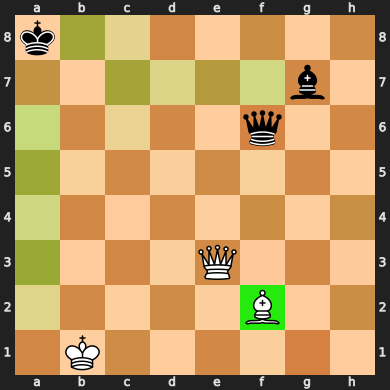

Explicación LIME para el FEN k7/6b1/5q2/8/8/4Q3/5B2/1K6 b - - 0 1
Played move: f6b2
[('g7=11', 0.8298145328877427), ('c1=30', 0.39346665281978016), ('c2=30', 0.2995000304204269), ('b5=30', 0.2695145177923789), ('b6=30', 0.2589145424463357), ('d2=30', 0.1979748628721765), ('b3=30', 0.19559440332302477), ('e2=30', 0.17883241292299012), ('b7=30', 0.17758476748834964), ('a1=30', 0.16722387270473327), ('b4=30', 0.15392207743239056), ('d1=30', 0.09871437138968353), ('a3=30', 0.0762788475427338), ('g8=30', -0.05475332128254809), ('a4=30', 0.05449947789560282), ('c4=30', 0.053938279843252335), ('b8=30', -0.0485762181744873), ('e3=27', -0.04855237690647389), ('d3=30', 0.0426512891272031), ('e8=30', 0.040019616325572105), ('g6=30', 0.032502267942783485), ('g1=30', 0.03222240805543976), ('a5=30', -0.03009313029814675), ('h1=30', -0.028095278472317693), ('h3=30', -0.026315832676703635), ('c6=30', -0.022743821196257744), ('g5=30', -0.022441388247751323), ('h8=30', -0.02158332871060888), ('e4=30', -

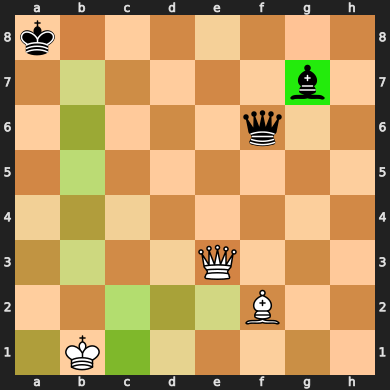

Explicación LIME para el FEN 1k6/8/8/8/8/8/7P/1K6 w - - 0 1
Played move: h2h4
[('h8=30', 0.31810014629869077), ('c8=30', 0.2878200740073793), ('f4=30', 0.280383757311635), ('e8=30', 0.2659060216360633), ('f8=30', 0.2635209982644037), ('d8=30', 0.2619163555468718), ('a8=30', 0.25827318719922626), ('g8=30', 0.2480489410579145), ('a7=30', 0.24398321255899239), ('d6=30', 0.23065499663692493), ('d2=30', 0.21780598889424818), ('d7=30', 0.19819011159736782), ('c7=30', 0.1972391196229329), ('e5=30', 0.1918356140071859), ('g5=30', 0.18399223550715638), ('h5=30', 0.17700039302833054), ('e3=30', 0.17379977480608316), ('e2=30', 0.16814733470659746), ('c5=30', 0.16353357736942747), ('f7=30', 0.16270762435282368), ('g4=30', 0.15832093353574558), ('c6=30', 0.15758596391684485), ('g3=30', 0.15606380793760075), ('e6=30', 0.15079517734559977), ('a4=30', 0.14299370976682266), ('a5=30', 0.14218383142993518), ('g7=30', 0.13927691035209777), ('f6=30', 0.13865819100823357), ('a6=30', 0.1368011774646905), ('e

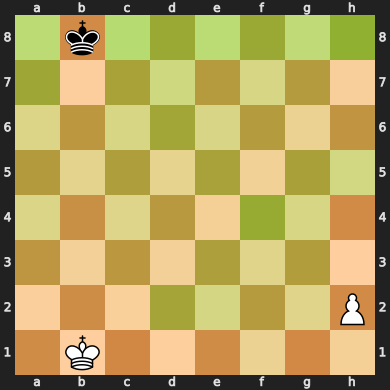

Explicación LIME para el FEN 1k6/ppp4r/8/8/8/8/PPP3R1/1K6 w - - 0 1
Played move: g2g8
[('c8=30', 0.7961373239539292), ('d8=30', 0.7666787023671989), ('f8=30', 0.7357631255244316), ('e8=30', 0.6424800370442864), ('b7=18', 0.3591035226284553), ('h8=30', 0.3528997224185214), ('a7=18', 0.3495510949725236), ('c7=18', 0.32050267445030983), ('d5=30', 0.10671055996214585), ('f7=30', 0.10517365365745711), ('c4=30', 0.10083511912673498), ('f5=30', 0.08808932031535194), ('b3=30', 0.08076852899000674), ('h7=20', -0.06552596005668863), ('e7=30', 0.06548297080343982), ('d2=30', 0.051083803456292966), ('e6=30', 0.0499499282236146), ('f6=30', 0.04331259925421013), ('b5=30', -0.039743920030735694), ('d7=30', 0.03925574093845115), ('g1=30', -0.036999552035812185), ('h3=30', 0.035859945904898244), ('a3=30', -0.03517127469020582), ('a5=30', 0.03138741925734879), ('f3=30', 0.029244067644482227), ('f2=30', 0.026723264361591385), ('f4=30', 0.0232615672977609), ('c1=30', -0.022324012134799936), ('h2=30', 0.02

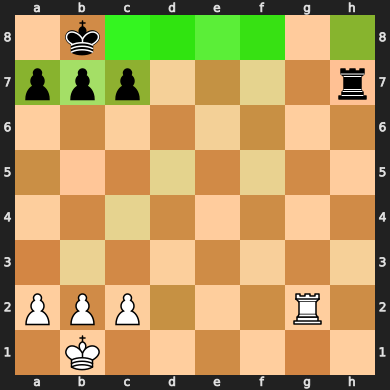

Explicación LIME para el FEN 1k6/ppp4r/8/8/8/8/PPP3R1/1K6 b - - 0 1
Played move: h7h1
[('g1=30', 0.8093232591828967), ('c1=30', 0.7971953490724497), ('d1=30', 0.7474484135589347), ('e1=30', 0.7308170204360601), ('f1=30', 0.6862209971397171), ('c2=23', 0.33429656688895815), ('b2=23', 0.3176542989266797), ('a2=23', 0.31128665909380226), ('g3=30', 0.12321448316803829), ('g7=30', 0.12160283276471615), ('g4=30', 0.1172626036098593), ('f2=30', 0.11060645040497037), ('g6=30', 0.09562942184761983), ('g2=26', -0.09418103386710247), ('g5=30', 0.08960688285101517), ('e8=30', -0.07790153154654933), ('e3=30', 0.06601054235384736), ('c8=30', -0.05113958303743815), ('d4=30', 0.04825471039848472), ('c5=30', 0.0477060386910252), ('d8=30', -0.04721320646407345), ('f4=30', 0.04263114066949355), ('g8=30', -0.04191897869987591), ('d2=30', 0.041715582540578965), ('h8=30', -0.04093107909398112), ('b6=30', 0.0368120820071196), ('e5=30', -0.03557563557760526), ('f6=30', 0.029195592414634763), ('a3=30', -0.0258

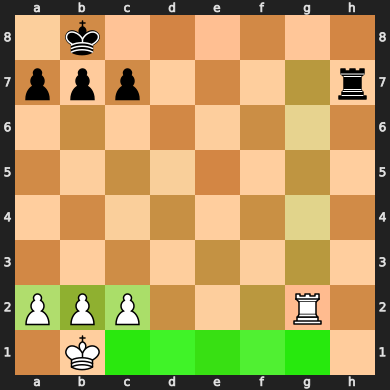

Explicación LIME para el FEN 1k6/ppp4b/8/8/8/8/PPP3R1/1K6 w - - 0 1
Played move: g2h2
[('d8=30', 0.3157900940060615), ('d2=30', 0.3093805406266967), ('e8=30', 0.3019845588387867), ('c8=30', 0.29875593887485863), ('f2=30', 0.2477901181973403), ('f8=30', 0.24771417549669558), ('g3=30', 0.23740090367425457), ('e2=30', 0.22819413707995578), ('g8=30', 0.2086946548399097), ('d6=30', 0.20774244913017928), ('a8=30', 0.17656880846942088), ('c2=23', 0.16652528867627522), ('e5=30', 0.16127346305895796), ('g4=30', 0.1584068528649914), ('h8=30', 0.15316205748054315), ('f3=30', 0.14353973095012063), ('e3=30', 0.141907624519283), ('f1=30', 0.1326721792234676), ('f4=30', 0.131606378583534), ('h5=30', 0.12917458436841497), ('g1=30', 0.11702277845715203), ('f5=30', 0.11670840501035236), ('c6=30', 0.11669637823364064), ('e6=30', 0.1157446508954329), ('g6=30', 0.11434506164065397), ('c3=30', 0.11403479257503848), ('a5=30', 0.11264204635619264), ('d5=30', 0.11165229888714293), ('b3=30', 0.11092274727447614

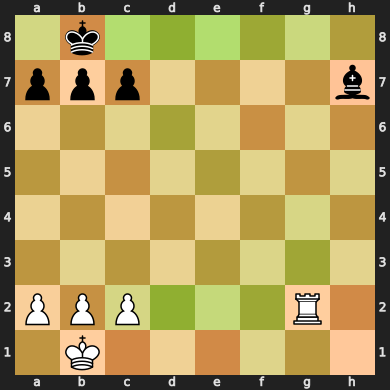

In [143]:
i = 0
for key, value in explainers.items():
    print(f'Explicación LIME para el FEN {key}')
    print(f'Played move: {moves_played[i]}')
    print(value.as_list())
    feature_weights = value.as_list()
    dibujar_tablero_con_mapa(key, feature_weights)
    i += 1
    """
    feature_weights = value.as_list()
    features, weights = zip(*feature_weights)
    plt.figure(figsize=(5, 10))
    bars = plt.barh(range(len(weights)), weights, color='skyblue')
    plt.yticks(range(len(features)), features)
    plt.xlabel('Peso de importancia')
    plt.title('Explicación LIME del movimiento')
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.gca().invert_yaxis()  # Opcional: pone la más importante arriba
    plt.show()

    """